In [1]:
# import libraries numpy, pandas, and scipy.stats module
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import re
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
def mergeDict(dict1, dict2):
   # Merge dictionaries and keep values of common keys in list
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = [dict1[key] , dict2[key]]
   return dict3


def plotting_num(df,col):
    # describe variable
    print(pd.DataFrame(df[col].describe()).T)
    print('')
    # bowley coefficient
    bowley = (df[col].quantile(0.75) - np.median(df[col]) - (np.median(df[col]) - df[col].quantile(0.25))) / (df[col].quantile(0.75) - df[col].quantile(0.25))
    if bowley > 0:
        comment = "<Right assimetry>"
    elif bowley < 0:
        comment = "<Left assimetry>"
    else:
        comment = "<Simmetric>"
    print("Bowley's Coefficient: ", round(bowley,2), comment)
    print('')
    ############ print('skew: ',skew(df[col]))  # qué me dice esto?
    pearson_coef = np.std(df[col]/np.mean(df[col]))
    print("Pearson's coefficient of variation: ", round(pearson_coef,2))
    # boxplot
    df.boxplot(column=col,showmeans=True)
    plt.show()
    # histogram
    plt.hist(df[col],alpha=0.75)
    plt.axvline(df[col].median(), color='red', linestyle='dashed', linewidth=1)
    plt.axvline(df[col].mean(), color='yellow', linestyle='dashed', linewidth=1)
    plt.title(col)
    
def plotting_cat(df, col):
    # Plot cualitative variables
    # relative frequencies of each variable
    frec_abs = round(df[col].value_counts(normalize=True, ascending=True),2)
    # remember: can also be done:
    ## tab = pd.crosstab(index= df['workclass'], columns='name you want to give')
    ## round(tab/tab.sum(),4)
    frec_abs = frec_abs[frec_abs > 0.00]
    
    # convert to dataframe and plot absolute frequencies
    ax = frec_abs.T.plot(kind='barh',alpha=0.75)
    ax.bar_label(ax.containers[0])
    plt.axvline(0.025, color='cyan', linestyle='dashed', linewidth=1)
    plt.title(col)
    plt.ylabel('Percentage')
    plt.xlim([0,1])
    plt.show()

def boxplot_customization(ax):
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor(col)
        legpatch.set_facecolor('None')
        
def dfs_in_one_boxplot(*args):
    # plot boxplots census train and test next to each other
    df_list = []
    start_names_df = len(args)//2
    for index,df in enumerate(args[0: start_names_df]):
        df = pd.DataFrame(df)
        df.drop('greater_than_50k', axis=1, inplace=True)
        data = df[df.describe().columns].assign(datasets=args[start_names_df + index])
        df_list.append(data)
    cdf = pd.concat(df_list)    
    mdf =pd.melt(cdf, id_vars=['datasets'], var_name=['Letter'])
    
    fig, ax = plt.subplots(figsize=(16,9))
    sns.boxplot(x="Letter", y="value", hue="datasets", data=mdf, showmeans=True, showfliers=False,linewidth=0.75).set_title('Distribution of quantitative variables')
    boxplot_customization(ax)
    plt.xlabel('')
    plt.ylabel('valores')

def plot_hist(col):
    # plot census train and census test histograms
    plt.hist(df_train[col],alpha=0.5, label = 'census train')
    plt.hist(df_test[col],alpha=0.5, label = 'census test')
    plt.title(f'Histogram for {col}')
    plt.legend()
    
def tabla_contingencia_frec_rel_con(df,col):
    # Exploratory analysis for qualitative data
    # Relative frequencies 
    frec_abs = round(df[col].value_counts(normalize=True, ascending=True),2)
    frec_abs = frec_abs[frec_abs > 0.025].index
    
    df = df[df[col].isin(frec_abs)]
    
    tab = pd.crosstab(index= df['greater_than_50k'], columns=df[col],margins=True)
    col_labels = tab.columns.to_list()
    col_labels[-1] = 'total_earns'
    
    tab.index = ['<50k','>50k',f'total_{col}']
    tab.columns = col_labels
    
    frec_tab = tab/tab.loc[f'total_{col}','total_earns']
    
    # ordering columns in education (nominal ordinal)
    if col == 'education':
        frec_tab = frec_tab[['10th', '11th','HS-grad','Assoc-acdm', 'Assoc-voc','Some-college','Bachelors','Masters','total_earns']]
    
    display(round(frec_tab,2) * 100)
    
    # ordering columns in education (nominal ordinal)
    frec_tab_mar = tab/tab.loc[f'total_{col}']
    if col == 'education':
        frec_tab_mar = frec_tab_mar[['10th', '11th','HS-grad','Assoc-acdm', 'Assoc-voc','Some-college','Bachelors','Masters','total_earns']]
    display(round(frec_tab_mar,2) * 100)
    
def cat_dataframe(df):
    # return a dataframe with only categorical variables and target variable
    cat = df.select_dtypes(include=['object'])
    cat['greater_than_50k'] = df['greater_than_50k']
    return cat

def create_frec_tab(df,col):
    # create frequencies dataframe for a variable
    return round(df[col].value_counts(normalize=True, ascending=True),2)

def frec_plot_for_var(df_train, df_test,col):
    # create frequencies plot for a variable
    d_train = create_frec_tab(df_train,col).to_dict()
    d_test = create_frec_tab(df_test,col).to_dict()
    
    # merge dictionaries
    merge_d = {**d_train, **d_test}
    #mergeDict(d_train, d_test,d)
    merge_d = {k:v for k,v in merge_d.items() if v != 0.0}

    # convert to dataframe and plot absolute frequencies
    ax = pd.DataFrame(merge_d, index = ['census_train','census_test']).T.plot(kind='barh',alpha=0.75)
    ax.bar_label(ax.containers[0])
    plt.axvline(0.025, color='cyan', linestyle='dashed', linewidth=1)
    plt.title(col)
    plt.ylabel('Percentage')
    plt.show()

def bootstrapping(df, df2, col):
    # bootstrapping to calculate if dataframes are from the same sample.
    boot_means = []
    for _ in range(10000):
        boot_sample = np.random.choice(df[col],replace=True, size=1000) # take a random sample each iteration
        boot_mean = np.mean(boot_sample) # calculate the mean for each iteration
        boot_means.append(boot_mean) # append the mean to boot_means
    boot_means_np = np.array(boot_means) # transform it into a numpy array for calculation
    p_value = (sum(boot_means_np > np.mean(df2[col]))/len(boot_means))
    return p_value

def range_df(df):
    # checking the range in our quantitative variables for census_train and census_test.
    return df[df.describe().columns].max()-df[df.describe().columns].min()

def unique_values_less25per(df):
    # returns a dictionary with all the values that appear <0.025
    min_values_quantity_d = {}
    for col in df.columns:
        if col != 'greater_than_50k':
            frec_abs = round(df[col].value_counts(normalize=True, ascending=True),2)
            frec_abs = frec_abs[frec_abs <= 0.025].index
            min_values_quantity_d[col] = frec_abs.tolist()
    return min_values_quantity_d

def unique_values_less25per_df(df):
    # returns a df with values <0.025 grouped
    d_unique_values_less25perc = unique_values_less25per(df)
    for col in d_unique_values_less25perc.keys():
        d_unique_values_less25perc_col = d_unique_values_less25perc[col]
        df[col].replace(d_unique_values_less25perc_col,'other_'+ col, inplace=True)
    return df

def find_rsquared(model):
    # find r squared in model.summary()
    model_sum = str(model.summary())
    start = model_sum.find('Pseudo R-squ.')
    end = model_sum[start:].find('\nTime')
    rsquared = model_sum[start:start+end]
    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
    final_list = [float(x) for x in re.findall(match_number, rsquared)]
    #rsquared = float(re.findall("\d+\.\d+", rsquared)[0])
    return final_list[0]

def find_combinations(S):
    result = []
    for i in range(len(S)+1):
      for c in itertools.combinations(S, i):
        if len(c)>0:
            result.append(c)
    return result

def find_r(df):
    warnings.filterwarnings("ignore")
    # find best r with all possible combinations
    combs = find_combinations(df.columns[:-1])
    d_combs = []
    for comb in combs:
        form = 'greater_than_50k ~ '
        for col in comb:
            if col == comb[0]:
                form = form + f'C({col})'
            else:
                form = form + f' + C({col})'
        try:
            model = smf.logit(formula= form , data = df).fit(disp=False)
            r = find_rsquared(model)
            d_combs.append([form, r])
        except:
            pass
    return d_combs

def count_vars(form):
    words = []
    for word in X_train.columns:
        if (form.find(word) != -1):
            words.append(word)
    return len(words)

def metrics(form):
    model = smf.logit(formula= form , data = train_data).fit(disp = False)
    prob_y_pred = model.predict(X_test)
    y_pred = (prob_y_pred.copy()>0.5)*1
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    d = {'accuracy': round(acc,3), 'recall': round(recall,3), 'precision': round(precision,3), 'f1_score': round(f1,3)}
    return pd.DataFrame(d.items(),columns=['metric','value']).set_index('metric')

def plot_confussion_matrix(y_test,y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Actual values');
    ax.xaxis.set_ticklabels(['<=50k', '>50k'])
    ax.yaxis.set_ticklabels(['<=50k', '>50k'])

def plot_confusion_metrics(form, y_test, y_pred):
    df = metrics(form)

    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1 = plot_confussion_matrix(y_test,y_pred)

    ax2 = fig.add_subplot(122)
    font_size=13
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = df.values, rowLabels = df.index, bbox=bbox, colLabels=df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

In [3]:
df_train = pd.read_csv('census_v2.csv')
df_test = pd.read_csv('census_test_v2.csv')
df = pd.concat([df_train, df_test],sort=False)

# categoricals df
cat_train = cat_dataframe(df_train)
cat_test = cat_dataframe(df_test)
cat = cat_dataframe(df)

# numericals df
num = df.select_dtypes(include=np.number)
num_no_target = num.loc[:, num.columns != 'greater_than_50k']

# <font color='#464646'>Definition of Variables</font>

### <font color='#7e7e7e'>Quantitative variables:</font>

**age:** The age of an individual.

**educaction_num:** the ID of each education level (variable "education").

**hours_per_week:** the working hours of each individual.

### <font color='#7e7e7e'>Variables Cualitativas:</font>

**education:** The levels of education that an individual can have.

**occupation:** The type of work of each individual.

**relationship:**  Represents the relationship status of an individual with another.

**marital_status:** The marital status that each individual can have.

**gender:** The gender of the individual.

**race:** Groups into which individuals are subdivided.

**workclass:** Representation of the work status that an individual may have.

**native_country:**  The individual's country of origin.

**greater_than_50k:** Whether an individual earns more than 50k a year or not. 

# <font color='#464646'>Are the samples random?
</font>

# <font color='#464646'>Does the relative frequencies of the unique values of each variable exceed the 2.5% needed to analyze the data?</font>

### <font color='#7e7e7e'>1. Bootstrapping method
<font color='#7e7e7e'>We are going to compare if the numerical variables of the samples come from the same distribution</font>

In [4]:
d_same_distribution = {}
num = df.select_dtypes(include=np.number)
for col in num.columns:
    p_value = bootstrapping(df_train, df_test, col)
    d_same_distribution[col] = p_value
    # H0: the samples are from the same distribution.   
    if d_same_distribution[col] < 0.05:
        # reject H0
        print('According to %s, we reject H0 (samples are NOT from the same distribution). Pvalue is %.3f.' % (col,round(p_value,2)))
    else:
        # fail to reject H0
        print('According to %s, we do not reject H0 (the samples are from the same distribution). Pvalue is % .3f.' % (col,round(p_value,2)))
    print('')

According to age, we do not reject H0 (the samples are from the same distribution). Pvalue is  0.340.

According to education_num, we do not reject H0 (the samples are from the same distribution). Pvalue is  0.540.

According to hours_per_week, we do not reject H0 (the samples are from the same distribution). Pvalue is  0.550.

According to greater_than_50k, we do not reject H0 (the samples are from the same distribution). Pvalue is  0.620.



### <font color='#7e7e7e'>2. Boxplots and Histograms
<font color='#7e7e7e'>We check if the distribution of the numerical data is similar in both samples.</font>

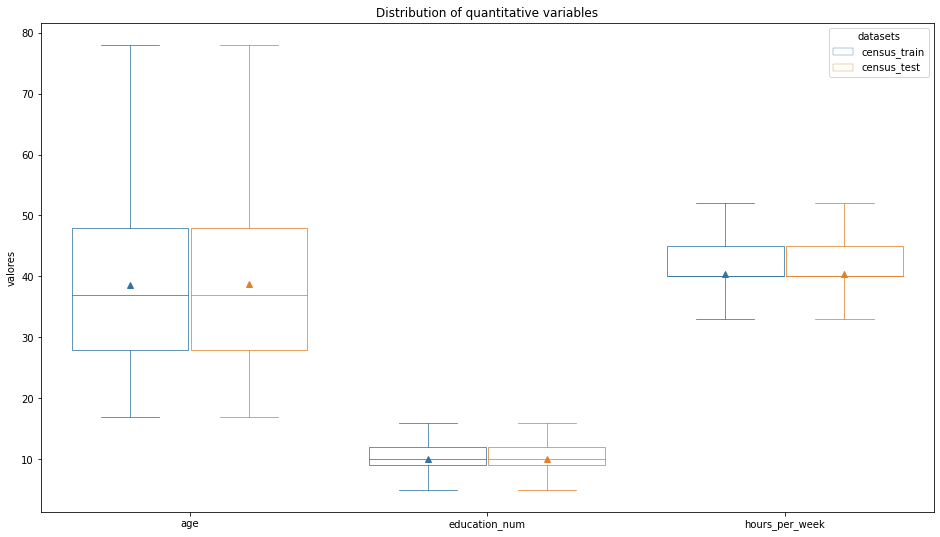

In [5]:
dfs_in_one_boxplot(df_train, df_test,'census_train','census_test')

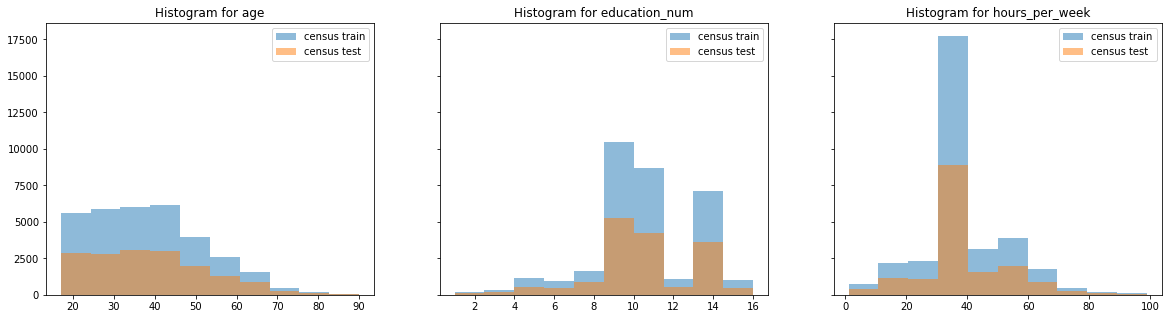

In [6]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(20,5))
for index,col in enumerate(num_no_target.columns):
    plt.subplot(1,3,index+1)
    plot_hist(col)

### <font color='#7e7e7e'>3. Relative frequency graphs
<font color='#7e7e7e'>We check if the frequencies of the categorical data are similar in both samples.</font>

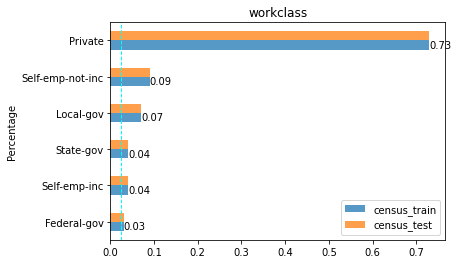

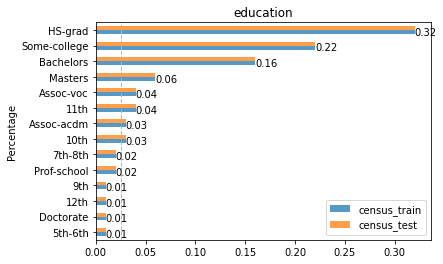

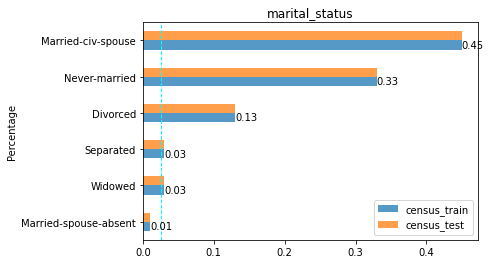

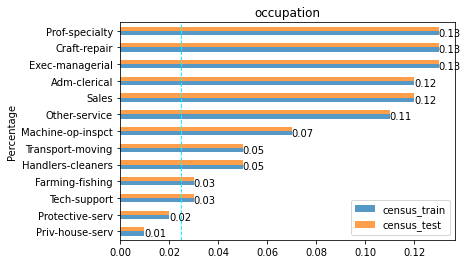

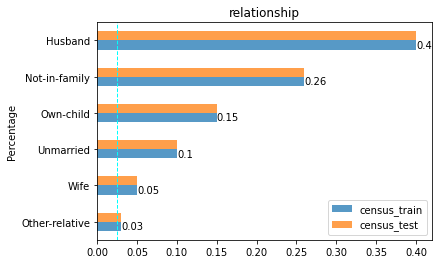

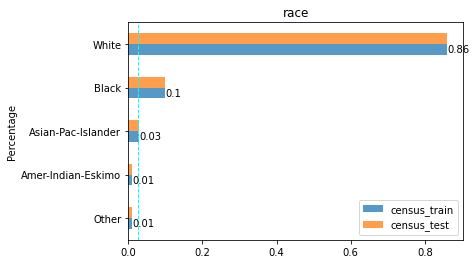

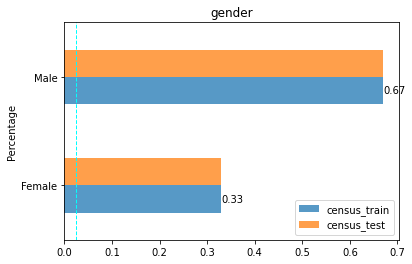

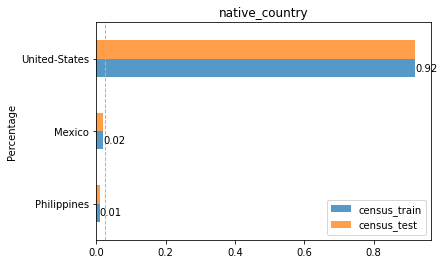

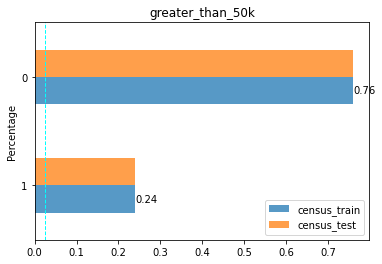

In [7]:
for col in cat.columns:
    frec_plot_for_var(cat_train, cat_test, col)

### <font color='#7e7e7e'>4. Dispersion and position measurements</font>

<font color='#7e7e7e'>Difference between the measurements of both samples</font>

In [8]:
round(df_train.describe()[1:].T - df_test.describe()[1:].T,2).T

,age,education_num,hours_per_week,greater_than_50k
mean,-0.19,0.01,0.05,0.0
std,-0.21,0.01,-0.13,0.0
min,0.00,0.00,0.00,0.0
25%,0.00,0.00,0.00,0.0
50%,0.00,0.00,0.00,0.0
75%,0.00,0.00,0.00,0.0
max,0.00,0.00,0.00,0.0


<font color='#7e7e7e'>Ranges of the quantitative variables for both samples.</font>

In [9]:
range_train = range_df(df_train).to_dict()
range_test = range_df(df_test).to_dict()
pd.DataFrame([range_train,range_test], index=['census_train','census_test']).iloc[:,:-1]

,age,education_num,hours_per_week
census_train,73,15,98
census_test,73,15,98


<font color='#7e7e7e'>Pearson's coefficient of variation</font>

In [10]:
d_pearson = {}
for col in num.columns:
    var_train = round(stats.variation(df_train[col]),2)
    var_test = round(stats.variation(df_test[col]),2)
    d_pearson[col] = [var_train,var_test]
pd.DataFrame(d_pearson, index=['census_train','census_test']).iloc[:,:-1]

,age,education_num,hours_per_week
census_train,0.35,0.26,0.31
census_test,0.36,0.25,0.31


So far we have not seen significant differences between the two samples.

### <font color='#7e7e7e'>6. Skewness and kurtosis</font>

In [11]:
for col in num.columns:
    if col != 'greater_than_50k':
        d_sym = {'census train': [], 'census test': []}
        skew_train = round(stats.skew(df_train[col]),2)
        skew_test = round(stats.skew(df_test[col]),2)

        curtosis_train = round(stats.kurtosis(df_train[col]),2)
        curtosis_test = round(stats.kurtosis(df_test[col]),2)

        d_sym['census train'] = [skew_train,curtosis_train]

        d_sym['census test'] = [skew_test,curtosis_test]

        print(col)
        display(pd.DataFrame(d_sym, index = ['skew','curtosis']))
        if col == 'age':
            print('The asymmetry is almost symmetrical although it has a straight tail.')
            print('The distribution is almost mesocúrtic although it is slightly platicúrtic.')
        elif col == 'education_num':
            print('The asymmetry is almost symmetrical although it has a left tail.')
            print('The distribution is almost mesocúrtic although it is slightly leptokurtic.')
        else:
            print('The asymmetry is almost symmetrical although it has a right tail.')
            print('The distribution is leptocurtica.')
        print('')

age


,census train,census test
skew,0.56,0.55
curtosis,-0.17,-0.22


The asymmetry is almost symmetrical although it has a straight tail.
The distribution is almost mesocúrtic although it is slightly platicúrtic.

education_num


,census train,census test
skew,-0.31,-0.33
curtosis,0.62,0.63


The asymmetry is almost symmetrical although it has a left tail.
The distribution is almost mesocúrtic although it is slightly leptokurtic.

hours_per_week


,census train,census test
skew,0.23,0.26
curtosis,2.92,3.02


The asymmetry is almost symmetrical although it has a right tail.
The distribution is leptocurtica.



Bias and kurtosis have similar values for each variable in both samples.

### <font color='#7e7e7e'>5. Nonparametric statistics</font>

<font color='#7e7e7e'> Mann-Whitney U rank test in two independent samples</font>

In [12]:
# H0: two independent samples come from the same distribution.
for col in num_no_target.columns:
    pvalue_MannWhitney = stats.mannwhitneyu(df_train[col],df_test[col], use_continuity=True, alternative='two-sided')
    if pvalue_MannWhitney[1] > 0.05:
        print('According to %s, we do not reject H0 (samples are from the same distribution). Pvalue is %.3f.' % (col, round(pvalue_MannWhitney[1],2)))
    print('')

According to age, we do not reject H0 (samples are from the same distribution). Pvalue is 0.320.

According to education_num, we do not reject H0 (samples are from the same distribution). Pvalue is 0.650.

According to hours_per_week, we do not reject H0 (samples are from the same distribution). Pvalue is 0.570.



<font color='#7e7e7e'> Chi-squared goodness-of-fit test</font>

In [13]:
# Used to compare if variables from != samples come from the same distribution
d_same_dist = {}
d_diff_dist = {}
for col in cat.columns:
    # H0: the samples come from the same distribution
    train = df_train[col].value_counts() / sum(df_train[col].value_counts())
    test = df_test[col].value_counts() / sum(df_train[col].value_counts())
    pvalue = stats.chisquare(train,test)[1]
    if pvalue < 0.05:
        # reject H0
        d_diff_dist[col] = pvalue
    else:
        # accept H0
        d_same_dist[col] = pvalue
print('We do not reject H0 (the samples come from the same distribution).')
round(pd.DataFrame([d_same_dist], index=['pvalue']),3)

We do not reject H0 (the samples come from the same distribution).


,workclass,education,marital_status,occupation,relationship,race,gender,native_country,greater_than_50k
pvalue,0.999,1.0,0.998,1.0,0.992,0.973,0.48,1.0,0.479


We have found no evidence to reject H0.

**We have no evidence that the samples may not come from the same distribution.**

# <font color='#464646'>Exploratory analysis</font>

### <font color='#7e7e7e'>1. One-dimensional analysis</font>

<font color='#7e7e7e'>Age unidimensional analysis</font>

       count       mean        std   min   25%   50%   75%   max
age  48841.0  38.643721  13.710617  17.0  28.0  37.0  48.0  90.0

Bowley's Coefficient:  0.1 <Right assimetry>

Pearson's coefficient of variation:  0.35


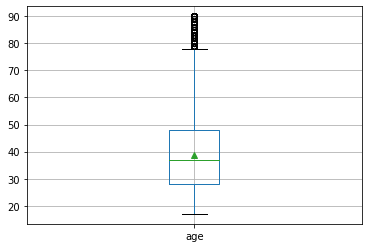

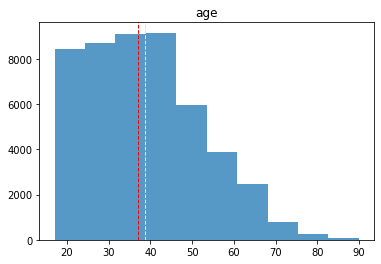

In [14]:
plotting_num(df,'age')
# the distribution is skewed to the right. The values decrease
# on the right.
# As the years get older, there is less data.
# There are outliers (between 80 and 90 years old).
# The mean ≈ median.

<font color='#7e7e7e'>Education_num unidimensional analysis</font>

                 count      mean       std  min  25%   50%   75%   max
education_num  48841.0  10.07809  2.570999  1.0  9.0  10.0  12.0  16.0

Bowley's Coefficient:  0.33 <Right assimetry>

Pearson's coefficient of variation:  0.26


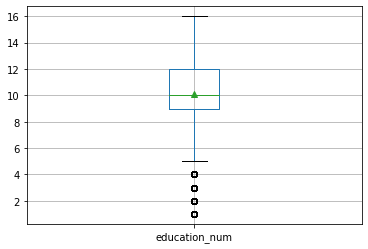

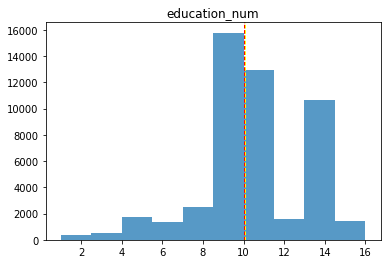

In [15]:
plotting_num(df,'education_num')

<font color='#7e7e7e'>Hours per week unidimensional analysis</font>

                  count       mean        std  min   25%   50%   75%   max
hours_per_week  48841.0  40.422391  12.391571  1.0  40.0  40.0  45.0  99.0

Bowley's Coefficient:  1.0 <Right assimetry>

Pearson's coefficient of variation:  0.31


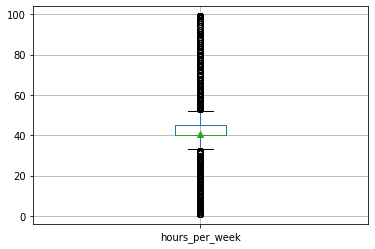

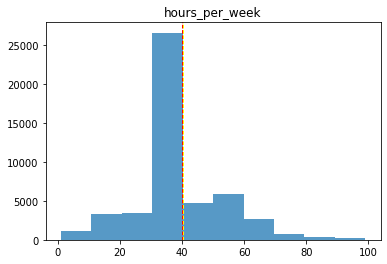

In [16]:
plotting_num(df,'hours_per_week')
# the distribution is skewed to the right. The values decrease
# on the right.
# There are many outliers at both ends.
# The mean ≈ median.

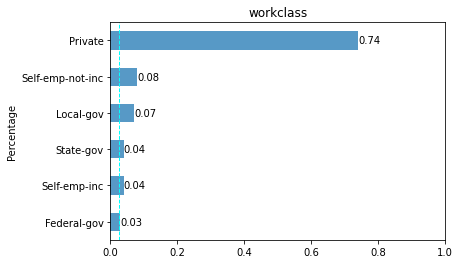

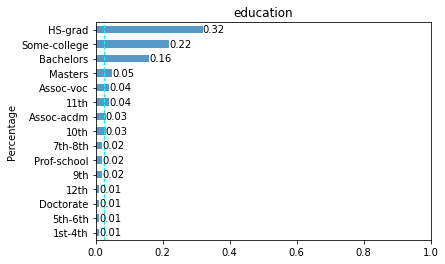

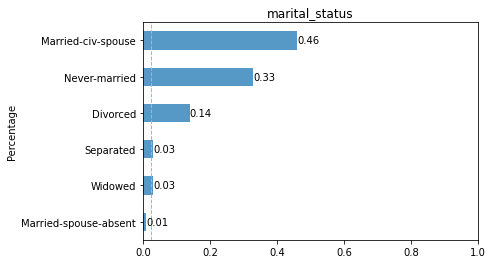

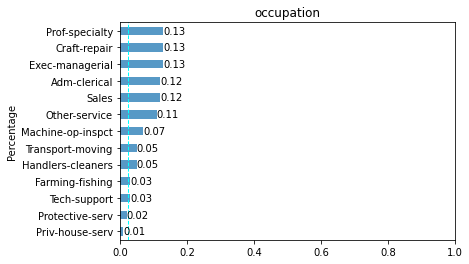

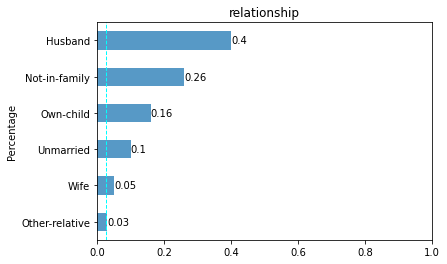

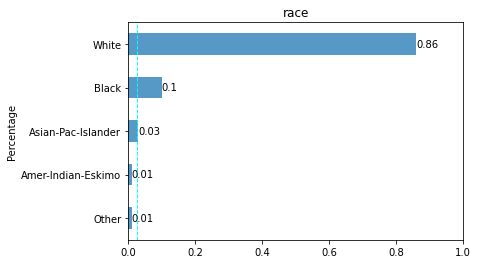

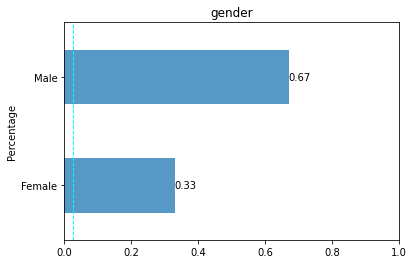

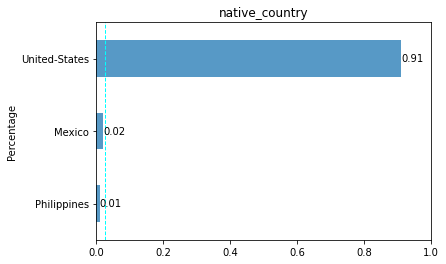

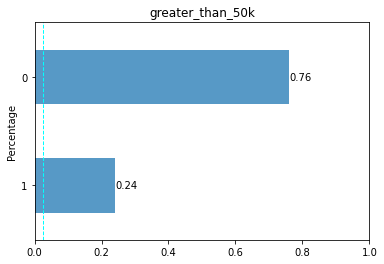

[None, None, None, None, None, None, None, None, None]

In [17]:
# Plot cualitative variables
# Exploratory analysis of qualitative data
cat_data = df.select_dtypes(include=['object'])
cat_data['greater_than_50k'] = df['greater_than_50k']
[plotting_cat(cat_data, col) for col in cat_data.columns]

* Possible sample bias:
      * 67% men.
      * 86% by race.
      * 91% from the US
      * 13% artisan repair.
    
    
* Anomaly:
     * Weekly hours reach 100 hours.
     * Outliers in numerical data.

### <font color='#7e7e7e'>2. Multidimensional analysis</font>

<font color='#7e7e7e'>Education frequencies and >50k </font>

In [18]:
tabla_contingencia_frec_rel_con(df,'education')

,10th,11th,HS-grad,Assoc-acdm,Assoc-voc,Some-college,Bachelors,Masters,total_earns
<50k,3.0,4.0,30.0,3.0,3.0,20.0,11.0,3.0,76.0
>50k,0.0,0.0,6.0,1.0,1.0,5.0,7.0,3.0,24.0
total_education,3.0,4.0,36.0,4.0,5.0,25.0,18.0,6.0,100.0


,10th,11th,HS-grad,Assoc-acdm,Assoc-voc,Some-college,Bachelors,Masters,total_earns
<50k,94.0,95.0,84.0,74.0,75.0,81.0,59.0,45.0,76.0
>50k,6.0,5.0,16.0,26.0,25.0,19.0,41.0,55.0,24.0
total_education,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


* Of those with masters (only 6%), half earn less than 50k.
* Of those with a bachelor's degree, only 41% earn more than 50k.
* The proportion of those who earn more corresponds, less in assoc-acdm and assoc-voc, to a higher level of studies.
* Completing a bachelor's degree gives you a 22% higher chance of earning more than 50k.
* Having gone through a university only gives you a 3% greater chance of earning more than 50k than having a high school degree (except assoc-acdm and assoc-voc).

<font color='#7e7e7e'>Occupation Frequencies and >50k</font>

In [19]:
tabla_contingencia_frec_rel_con(df,'occupation')

,Adm-clerical,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Prof-specialty,Sales,Tech-support,Transport-moving,total_earns
<50k,11.0,11.0,7.0,3.0,4.0,6.0,11.0,8.0,9.0,2.0,4.0,75.0
>50k,2.0,3.0,6.0,0.0,0.0,1.0,0.0,6.0,3.0,1.0,1.0,25.0
total_occupation,13.0,14.0,14.0,3.0,5.0,7.0,11.0,14.0,12.0,3.0,5.0,100.0


,Adm-clerical,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Prof-specialty,Sales,Tech-support,Transport-moving,total_earns
<50k,86.0,77.0,52.0,88.0,93.0,88.0,96.0,55.0,73.0,71.0,80.0,75.0
>50k,14.0,23.0,48.0,12.0,7.0,12.0,4.0,45.0,27.0,29.0,20.0,25.0
total_occupation,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


* It is curious that the world of repairs is 14% of the sample <- Possible sample bias.

* Almost half of those who are managers and specialists charge more than 50k.

<font color='#7e7e7e'>Relationship Frequencies and >50k</font>

In [20]:
tabla_contingencia_frec_rel_con(df,'relationship')

,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,total_earns
<50k,22.0,23.0,3.0,15.0,10.0,3.0,76.0
>50k,18.0,3.0,0.0,0.0,1.0,2.0,24.0
total_relationship,40.0,26.0,3.0,16.0,10.0,5.0,100.0


,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,total_earns
<50k,55.0,90.0,97.0,99.0,94.0,53.0,76.0
>50k,45.0,10.0,3.0,1.0,6.0,47.0,24.0
total_relationship,100.0,100.0,100.0,100.0,100.0,100.0,100.0


* Only married people earn, almost half, more than 50k.

<font color='#7e7e7e'>Hours_per_week Frequencies and >50k</font>

<AxesSubplot:xlabel='greater_than_50k', ylabel='hours_per_week'>

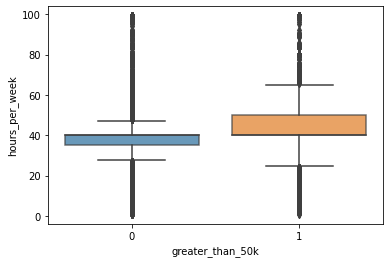

In [21]:
sns.boxplot(x='greater_than_50k',y='hours_per_week',data=df, boxprops=dict(alpha=.73))

* Those who earn more than 50k spend more hours on average.

# <font color='#464646'>We group unique values with a frequency less than 2.5%</font>

In [22]:
# convert to categories all our variables to be able to group values
# that appear <0.025.
age = df.age.values.astype(str)
education_num = df.education_num.values.astype(str)
hours_per_week = df.hours_per_week.values.astype(str)

df['age'] = age
df['education_num'] = education_num
df['hours_per_week'] = hours_per_week

# returns all the dataframes with its values that appear <0.025 in groups.
df = unique_values_less25per_df(df)

# <font color='#464646'>Correlations and Associations</font>

### <font color='#7e7e7e'>1. Chi-squared test of independence</font>
<font color='#7e7e7e'>Checks if the Boolean target variable with each categorical variable are independent</font>

In [23]:
print('Association greater_than_50k VS categorical')
d_association = {}
# H0: there is no relation between the variables.
for col in cat.columns:
    if col != 'greater_than_50k':
        tab = pd.crosstab(df['greater_than_50k'],df[col])
        stat, p, dof, expected = stats.chi2_contingency(tab)
        alpha = 0.05
        if p <= alpha: 
            # reject H0
            d_association[col + ' and >50k'] = [round(p,2),'We reject H0. Dependence between the variables is observed.'] 
        else: 
            # failt to reject H0
            d_association[col + ' and >50k'] = [round(p,2),'We do not reject H0. No dependence is observed between the variables.'] 

pd.DataFrame(d_association, index=['Pvalue','Result']).T

Association greater_than_50k VS categorical


,Pvalue,Result
workclass and >50k,0.0,We reject H0. Dependence between the variables...
education and >50k,0.0,We reject H0. Dependence between the variables...
marital_status and >50k,0.0,We reject H0. Dependence between the variables...
occupation and >50k,0.0,We reject H0. Dependence between the variables...
relationship and >50k,0.0,We reject H0. Dependence between the variables...
race and >50k,0.0,We reject H0. Dependence between the variables...
gender and >50k,0.0,We reject H0. Dependence between the variables...
native_country and >50k,0.0,We reject H0. Dependence between the variables...


In [24]:
print('Regressor variable  VS regressor variable')
# H0: there is no relation between the variables.
var1 = []
var2 = []
result = []
names = []
for col in cat.columns:
    for col2 in cat.columns:
        if col != 'greater_than_50k' and col2 != 'greater_than_50k' and col2 != col:
            tab = pd.crosstab(df[col],df[col2])
            stat, p, dof, expected = stats.chi2_contingency(tab)
            alpha = 0.05
            
            if col2+col not in names:
                var1.append(col)
                var2.append(col2)
                names.append(col+col2)

                if p <= alpha:
                    result.append('We reject H0. There may be dependency between variables.') 
                else: 
                    result.append('We do not reject H0. There is no dependency between the variables.') 
d_corr = {'var1': var1, 'var2': var2, 'result': result}
pd.DataFrame(d_corr)

Regressor variable  VS regressor variable


,var1,var2,result
0,workclass,education,We reject H0. There may be dependency between ...
1,workclass,marital_status,We reject H0. There may be dependency between ...
2,workclass,occupation,We reject H0. There may be dependency between ...
3,workclass,relationship,We reject H0. There may be dependency between ...
4,workclass,race,We reject H0. There may be dependency between ...
5,workclass,gender,We reject H0. There may be dependency between ...
6,workclass,native_country,We reject H0. There may be dependency between ...
7,education,marital_status,We reject H0. There may be dependency between ...
8,education,occupation,We reject H0. There may be dependency between ...
9,education,relationship,We reject H0. There may be dependency between ...


All variables are associated except gender and native_country.

It is not a good sign for our future model.

# <font color='#464646'>Logistic regression</font>
<font color='#7e7e7e'>We have found no evidence that the samples do not belong to the same distribution.</font>

In [57]:
X_train, X_test, y_train, y_test = df_train.drop(columns=['greater_than_50k']), df_test.drop(columns=['greater_than_50k']) ,df_train['greater_than_50k'], df_test['greater_than_50k']

train_data = X_train.copy()
train_data['greater_than_50k'] = y_train

train_data = train_data.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
# finding best R2 and formula
d_combs = find_r(train_data)

In [58]:
results = pd.DataFrame(d_combs, columns=['form','r2'])
results['number_vars'] = list(map(lambda x: count_vars(x),results['form']))

In [59]:
for n in results['number_vars'].unique():
    df_filter = results[results['number_vars'] == n]
    max_r2 = df_filter['r2'].max()
    form = df_filter[df_filter['r2'] == max_r2]['form'].values[0]
    if max_r2 >= np.median(results['r2']):
        print('For %d variables we have a R2 of %.4f. Form: %s' % (n,max_r2,form))
        print('')

For 3 variables we have a R2 of 0.3412. Form: greater_than_50k ~ C(age) + C(education) + C(relationship)

For 4 variables we have a R2 of 0.3459. Form: greater_than_50k ~ C(age) + C(education) + C(relationship) + C(native_country)

For 5 variables we have a R2 of 0.3482. Form: greater_than_50k ~ C(age) + C(education) + C(marital_status) + C(relationship) + C(gender)

For 6 variables we have a R2 of 0.3637. Form: greater_than_50k ~ C(age) + C(education) + C(marital_status) + C(race) + C(hours_per_week) + C(native_country)

For 7 variables we have a R2 of 0.3702. Form: greater_than_50k ~ C(age) + C(education) + C(relationship) + C(race) + C(gender) + C(hours_per_week) + C(native_country)

For 8 variables we have a R2 of 0.3702. Form: greater_than_50k ~ C(age) + C(education_num) + C(relationship) + C(race) + C(gender) + C(hours_per_week) + C(native_country)



**The combination of variables created does not give us good results.**
**As the regressor variables are associated with each other, we prefer to choose a model that has a similar r2 and fewer variables.**

Our option may be between choosing a **3 to 4 regressor variables model.**

For 3 variables (education, occupation, relationship) we have a r2 of 0.3096.

For 4 variables (education, occupation, relationship, hours_per_week) we have a r2 of 0.3195. 

In [60]:
form = 'greater_than_50k ~ education + occupation + relationship + hours_per_week'
model = smf.logit(formula= form , data = train_data).fit()
#model.summary()

         Current function value: 0.370910
         Iterations: 35


In [62]:
prob_y_pred = model.predict(X_test)

In [63]:
y_pred = (prob_y_pred.copy()>0.5)*1

### <font color='#7e7e7e'>Metrics for 4 regressor variables</font>

         Current function value: 0.370910
         Iterations: 35


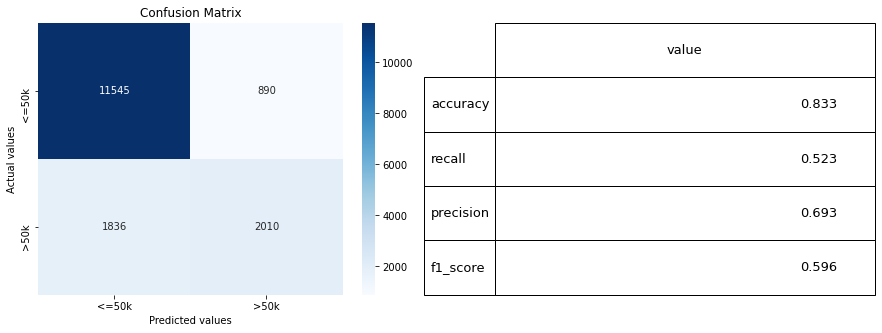

In [66]:
form = 'greater_than_50k ~ education + occupation + relationship + hours_per_week'
model = smf.logit(formula= form , data = train_data).fit(disp=False)
prob_y_pred = model.predict(X_test)
y_pred = (prob_y_pred.copy()>0.5)*1
plot_confusion_metrics(form,y_test, y_pred)

* The percentage of positive predictions that were correct is 83.1%.

* The percentage of positive cases detected is 67.1%.

* The proportion of positive cases that were correctly identified by the algorithm is 53.7%.

* The most general quality percentage of the model (F1 score) is 59.7%.

* Es correcto que 8620 ganan <50k.

* Error Tipo1: Realmente 748 ganan <50k pero me predicen que ganan más.

* Error Tipo2: Realmente 1315 ganan >50k pero me predicen que ganan menos.

* Es correcto que 1528 ganan >50k.

### <font color='#7e7e7e'>Metrics for 3 regressor variables</font>

         Current function value: 0.376129
         Iterations: 35


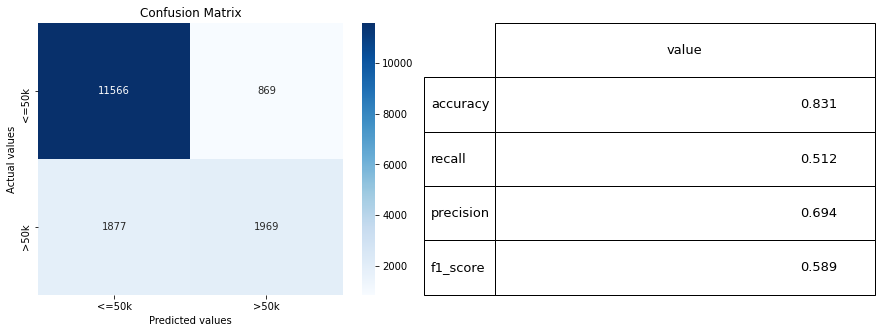

In [68]:
form = 'greater_than_50k ~ education + occupation + relationship'
model = smf.logit(formula= form , data = train_data).fit(disp=False)
prob_y_pred = model.predict(X_test)
y_pred = (prob_y_pred.copy()>0.5)*1
plot_confusion_metrics(form, y_test, y_pred)

* El porcentaje de predicciones positivas que fueron correctas es de un 83%.

* El porcentaje de casos positivos detectados es de un 67.3%.

* La proporción de casos positivos que fueron correctamente identificados por el algoritmo es de un 52.3%.

* El porcentaje de calidad más general del modelo (F1 score) es del 58.9%.

* Es correcto que 8645 ganan <50k.

* Error Tipo1: Realmente 723 ganan <50k pero me predicen que ganan más.

* Error Tipo2: Realmente 1356 ganan >50k pero me predicen que ganan menos.

* Es correcto que 1487 ganan >50k.

### <font color='#7e7e7e'>Metrics for 5 regressor variables</font>

         Current function value: 0.364190
         Iterations: 35


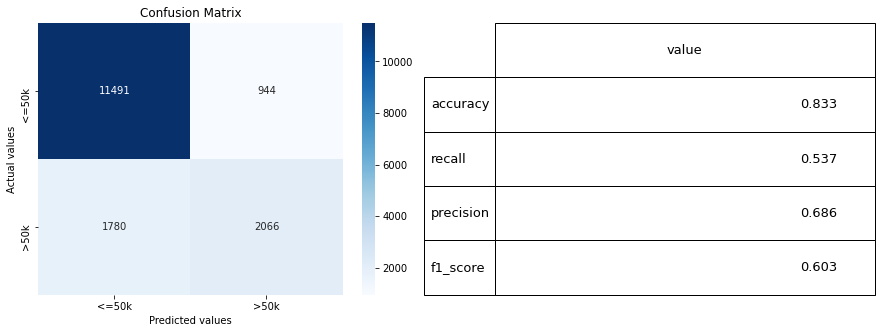

In [69]:
form = 'greater_than_50k ~ age + education + occupation + relationship + hours_per_week'
model = smf.logit(formula= form , data = train_data).fit(disp=False)
prob_y_pred = model.predict(X_test)
y_pred = (prob_y_pred.copy()>0.5)*1
plot_confusion_metrics(form,y_test, y_pred)

* The percentage of positive predictions that were correct is 83.1%.

* The percentage of positive cases detected is 67.1%.

* The proportion of positive cases that were correctly identified by the algorithm is 53.7%.

* The most general quality percentage of the model (F1 score) is 59.7%.

* It is correct that 8656 win <50k.

* Type1 Error: Really 712 earn <50k but I predict they earn more.

* Type2 Error: Really 1,332 earn> 50k but I predict they earn less.

* It is correct that 1511 win> 50k.

**Depending on the question we ask ourselves, we will be more interested in choosing one model or another of the ones we have just analyzed.**

**In general terms, the 4-variable model (education, occupation, relationship and hours_per_week) may be the most suitable to predict whether the individual earns more or less than 50k.**